In [2]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
from pymongo import MongoClient
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
def get_mongo_database(db_name, host='localhost',
                       port=27017, username=None, password=None):
    """ Get named database from MongoDB with/out authentication """
    # make Mongo connection with/out authentication
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s/%s'%(username, password, host, db_name)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)

    return conn[db_name]

def mongo_coll_to_dicts(dbname='test', collname='test',
                        query={}, del_id=True, **kw): 

    db = get_mongo_database(dbname, **kw)
    res = list(db[collname].find(query))

    if del_id:
        for r in res:
            r.pop('_id')

    return res

def mongo_to_dataframe(db_name, collection, query={},
                       host='localhost', port=27017,
                       username=None, password=None, no_id=True):
    """ create a dataframe from mongodb collection """
    db = get_mongo_database(db_name, host, port, username, password)
    cursor = db[collection].find(query)
    df =  pd.DataFrame(list(cursor))

    if no_id: 
        del df['_id']

    return df

def dataframe_to_mongo(df, db_name, collection,
                       host='localhost', port=27017,
                       username=None, password=None):
    """ save a dataframe to mongodb collection """
    db = get_mongo_database(db_name, host, port, username, password)
    records = df.to_dict('records')
    db[collection].insert_many(records)

In [4]:
DB_NOBEL_PRIZE='nobel_prize'
COLL_WINNERS='winners'
COLL_WINNERS_CLEAN='winners_clean'
COLL_MIN_BIO='mini_bio'
COLL_FULL_DATA='full_data'

In [5]:
df=mongo_to_dataframe(DB_NOBEL_PRIZE, COLL_FULL_DATA)

In [6]:
% matplotlib inline

In [7]:
plt.rcParams['figure.figsize'] = (8, 4)

In [91]:
df.date_of_birth=pd.to_datetime(df.date_of_birth)
df.date_of_death=pd.to_datetime(df.date_of_death)

In [9]:
df.head()

,award_age,category,country,date_of_birth,date_of_death,gender,image_urls,link,mini_bio,name,place_of_birth,place_of_death,receiver_nature,text,year
0,46.0,Physics,Austria,1887-08-12 00:00:00,1961-01-05,male,[http://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Erwin_Schr%C3%B6...,<p><b>Erwin Rudolf Josef Alexander Schrödinger...,Erwin Schrödinger,Vienna,Vienna,NaN,"Erwin Schrödinger , Physics, 1933",1933
1,45.0,Physics,Austria,1900-04-25,1958-12-15,male,[http://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Wolfgang_Pauli,<p><b>Wolfgang Ernst Pauli</b> (25 April 1900 ...,Wolfgang Pauli,Vienna,Zürich,NaN,"Wolfgang Pauli , Physics, 1945",1945
2,46.0,Peace,Myanmar (Burma),1945-06-19,1970-01-01,female,[http://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Aung_San_Suu_Kyi,"<p><br></p><p><b>Aung San Suu Kyi</b>, (<a hre...",Aung San Suu Kyi,Yangon,NaN,NaN,"Aung San Suu Kyi , Peace, 1991",1991
3,37.0,Physics,Italy,1901-09-29,1954-11-28,male,[http://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Enrico_Fermi,<p><b>Enrico Fermi</b> (<small>Italian: </smal...,Enrico Fermi,Rome,Chicago,NaN,"Enrico Fermi , Physics, 1938",1938
4,52.0,Literature,India,1861-05-07 00:00:00,1941-08-07,male,[http://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Rabindranath_Tagore,"<p><b>Rabindranath Tagore</b><sup id=""cite_ref...",Rabindranath Tagore,Kolkata,Kolkata,NaN,"Rabindranath Tagore , Literature, 1913",1913


In [99]:
g_cat_gender=df.groupby(['category','gender'])
#cool access to values of the groups
g_cat_gender.get_group(('Economics','female'))

,award_age,category,country,date_of_birth,date_of_death,gender,image_urls,link,mini_bio,name,place_of_birth,place_of_death,receiver_nature,text,year
643,76.0,Economics,United States,1933-08-07,2012-06-12,female,[http://upload.wikimedia.org/wikipedia/commons...,https://en.wikipedia.org/wiki/Elinor_Ostrom,"<p><b>Elinor Claire</b> ""<b>Lin</b>"" <b>Ostrom...",Elinor Ostrom,Los Angeles,Bloomington,NaN,"Elinor Ostrom , Economics, 2009",2009


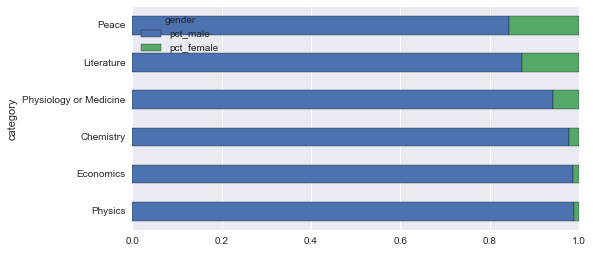

In [121]:
#total proportion of female winners by category
df_cat_gender=g_cat_gender.size().unstack()
df_cat_gender['total']=df_cat_gender.sum(axis=1)
df_cat_gender['pct_female']=df_cat_gender['female']/df_cat_gender['total']
df_cat_gender['pct_male']=df_cat_gender['male']/df_cat_gender['total']
df_cat_gender[['pct_male','pct_female']].sort_values('pct_female',ascending=True).plot(kind='barh',stacked=True)

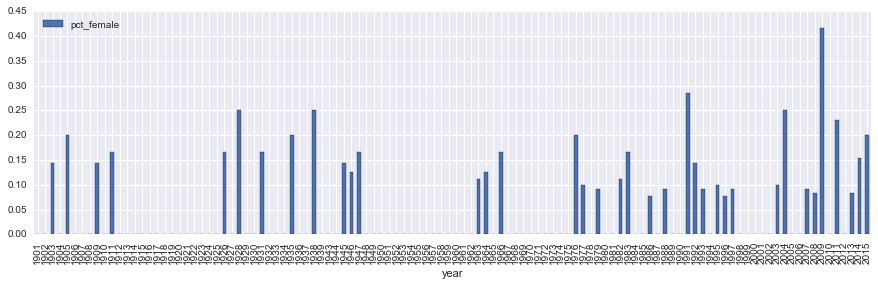

In [163]:
#evolution of the total proportion of female winners
df_hist_gender=df.groupby(['year','gender'])['gender'].count().unstack().reset_index()
df_hist_gender['pct_female']=df_hist_gender['female']/(df_hist_gender['female']+df_hist_gender['male'])
df_hist_gender.plot('year','pct_female',kind='bar',figsize=(15,4))

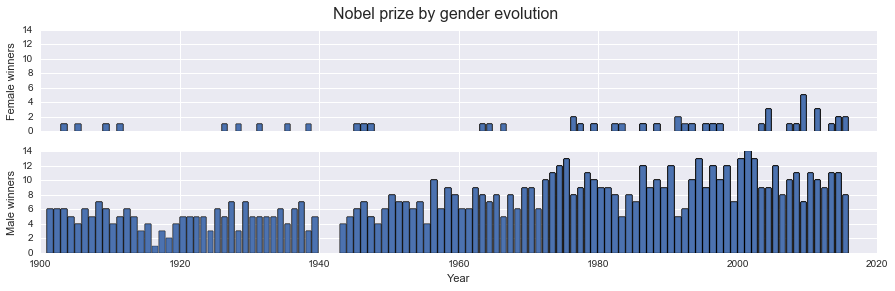

In [168]:
#evolution of the total proportion of female winners
new_index=pd.Index(df.year,name='year')
df_hist_gender=df.groupby(['year','gender']).size().unstack().reindex(new_index)

fig, axes=plt.subplots(nrows=2,ncols=1,sharex=True,sharey=True, figsize=(15,4))

ax_f=axes[0]
ax_m=axes[1]

fig.suptitle('Nobel prize by gender evolution',fontsize=16)

ax_f.bar(df_hist_gender.index, df_hist_gender.female)
ax_f.set_ylabel('Female winners')

ax_m.bar(df_hist_gender.index, df_hist_gender.male)
ax_m.set_ylabel('Male winners')
ax_m.set_xlabel('Year')

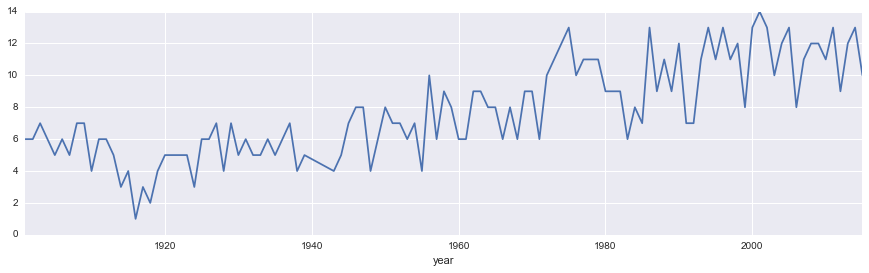

In [161]:
df.groupby('year')['name'].size().plot()

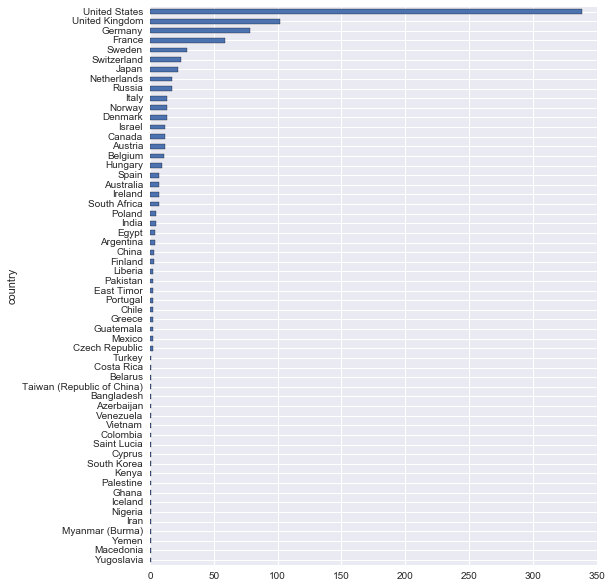

In [175]:
df.groupby(['country']).size().sort_values(ascending=True).plot(kind='barh',figsize=(8,10))

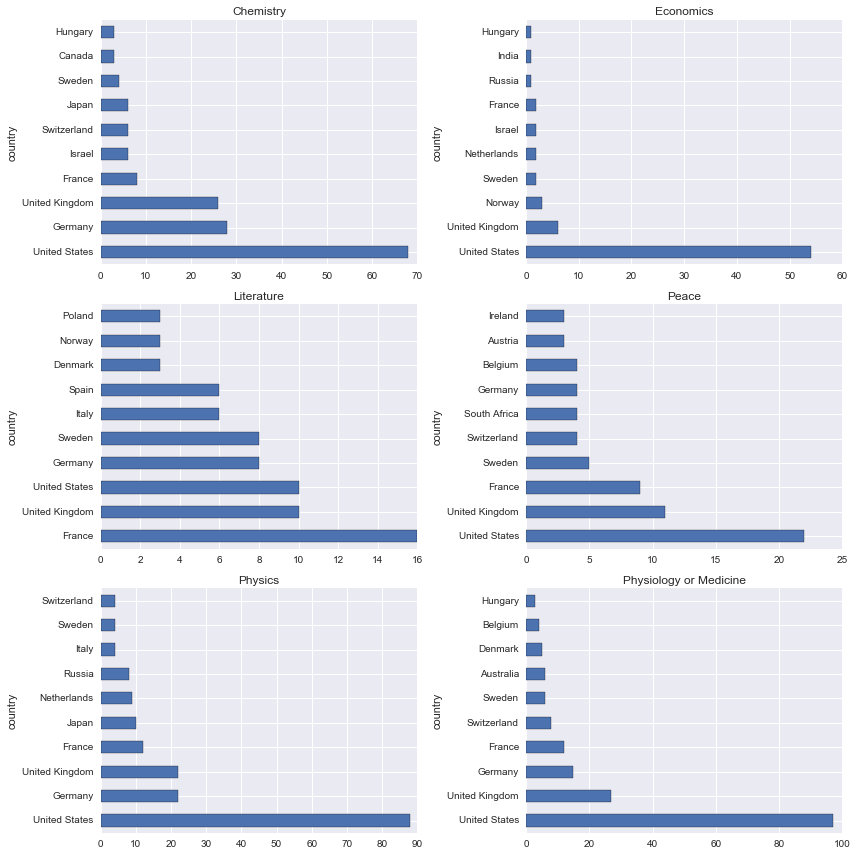

In [210]:
#create a multiplot to see the top 10 countries for each categorie in term of total number of winners
g_country_cat=df.groupby(['country','category']).size().unstack()
N_ROWS=3
N_COLS=2
fig,axes=plt.subplots(N_ROWS,N_COLS,figsize=(12,12))
for i,(col_label, col) in enumerate(g_country_cat.iteritems()):
    ax=axes[i/N_COLS,i%N_COLS]
    col=col.sort_values(ascending=False)[:10]
    col.plot(kind='barh',ax=ax)
    ax.set_title(col_label)
plt.tight_layout()

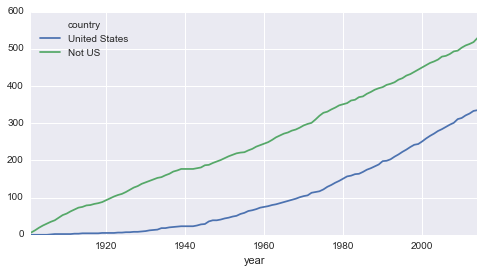

In [250]:
#look at historical trends by country
new_index=pd.Index(range(min(df.year),max(df.year)), name='year')
g_year_country=df.groupby(['year','country']).size().unstack().reindex(new_index)
not_us=g_year_country.columns.tolist()
not_us.remove('United States')
g_year_country['Not US']=g_year_country[not_us].sum(axis=1)

g_year_country[['United States','Not US']].fillna(0).cumsum().plot()

In [252]:
#historical trends by regions (main winning countries by regions)
regions=[
    {
        'label':'America',
        'countries':['United States','Canada']
    },
    {
        'label':'Europe',
        'countries':['United Kingdom','Germany','France']
    },
    {
        'label':'Asia',
        'countries':['Russia','China','Japan']
    }
]
for region in regions:
    g_year_country[region['label']] = g_year_country[region['countries']].sum(axis=1)
g_year_country[[r['label'] for r in regions]].fillna(0).cumsum().plot()

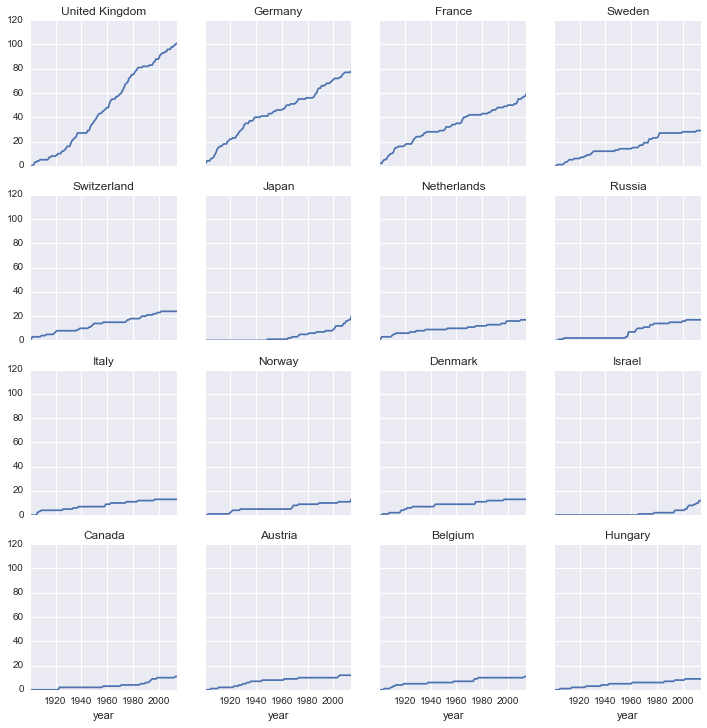

In [263]:
#let's take a look at the trajectory of the 16 main countries excl. the US
#identification of 16 main countries
g_country=df.groupby('country').size().sort_values(ascending=False)

N_ROWS=4
N_COLS=4

fig, axes= plt.subplots(N_ROWS, N_COLS, figsize=(12,12), sharex = True, sharey = True)

for i, nat in enumerate(g_country.index[1:17]):
    ax=axes[i/N_COLS, i%N_COLS]
    g_year_country[nat].fillna(0).cumsum().plot(ax=ax)
    ax.set_title(nat)

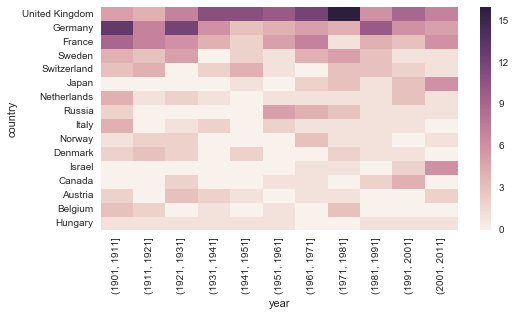

In [271]:
#drawing a heatmap for those countries
bins=np.arange(df.year.min(),df.year.max(),10)
g_decades_country=df.groupby([
        pd.cut(df.year, bins=bins, precision=0),
        'country']).size().unstack().fillna(0)
plt.figsize=(16,8)
sns.heatmap(g_decades_country[g_country.index[1:17]].transpose())

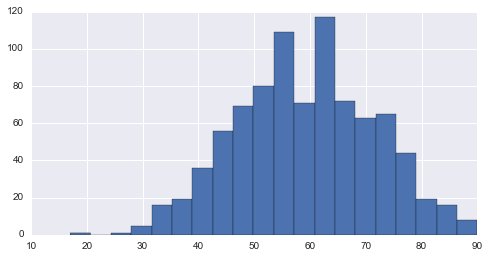

In [272]:
#distribution of age at the time of price attribution
df['award_age'].hist(bins=20)

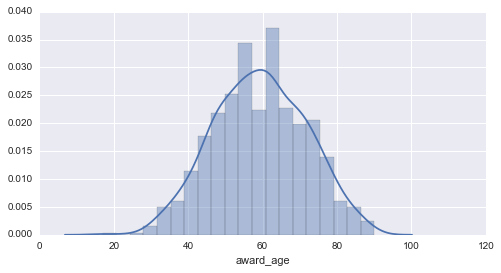

In [276]:
sns.distplot(df['award_age'].dropna())

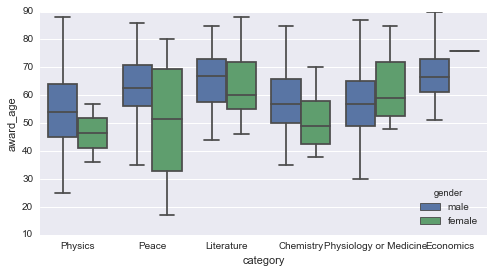

In [289]:
#using boxplots
df_aw=df[df.award_age.notnull()]
palette={'male':'blue', 'female':'red'}
sns.boxplot(y='award_age', x='category', data=df_aw, hue='gender')

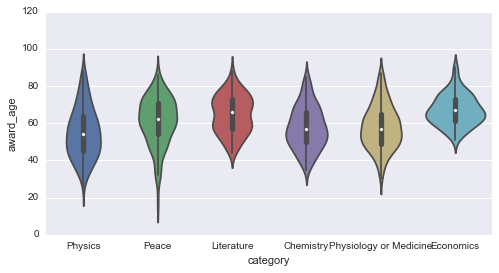

In [293]:
#using volinplots
df_aw=df[df.award_age.notnull()]
palette={'male':'blue', 'female':'red'}
sns.violinplot(y='award_age', x='category', data=df_aw)

In [27]:
#looking at age of death
df['age_of_death']=(pd.to_datetime(df.date_of_death,errors='coerce') - pd.to_datetime(df.date_of_birth,errors='coerce')).dt.days/365 

In [35]:
#problem with age pf death ==> should rerun the cleaning steps and identify issue
df[df.age_of_death<40].shape

(248, 16)

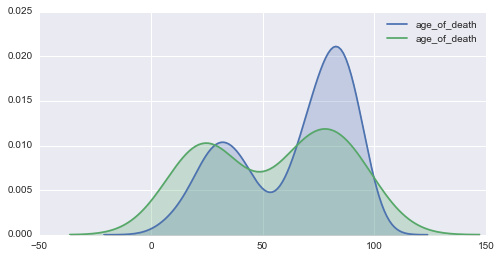

In [30]:
sns.kdeplot(df.loc[(df.age_of_death>0)&(df.gender=='male'),'age_of_death'],shade=True)
sns.kdeplot(df.loc[(df.age_of_death>0)&(df.gender=='female'),'age_of_death'],shade=True)

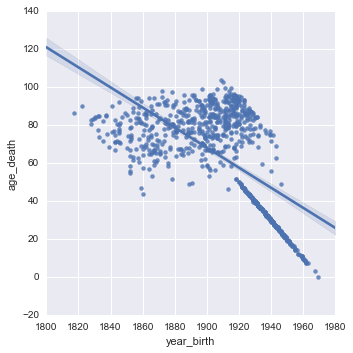

In [33]:
data=DataFrame({'age_death':df[(df.age_of_death>0)&(df.date_of_death.notnull())].age_of_death,'year_birth':df[df.age_of_death>0].date_of_birth.dt.year})
sns.lmplot('year_birth','age_death',data)

In [38]:
#aller récupérer le born_in field dans le pipe de cleaning pour pouvoir sortir la heatmap born_in ==> moved to

Index([      u'award_age',        u'category',         u'country',
         u'date_of_birth',   u'date_of_death',          u'gender',
            u'image_urls',            u'link',        u'mini_bio',
                  u'name',  u'place_of_birth',  u'place_of_death',
       u'receiver_nature',            u'text',            u'year',
          u'age_of_death'],
      dtype='object')